<a href="https://colab.research.google.com/github/seoes/odyssey-ai/blob/seo/tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 기본 설정

## 첫 설정

In [1]:
import torch
import numpy as np
import cv2

from IPython.display import clear_output, display, Image

## YOLOv5 설치

In [2]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Cloning into 'yolov5'...
remote: Enumerating objects: 16078, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 16078 (delta 6), reused 9 (delta 1), pack-reused 16056
Receiving objects: 100% (16078/16078), 14.72 MiB | 17.23 MiB/s, done.
Resolving deltas: 100% (11038/11038), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.6/646.6 kB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-12-2 Python-3.10.12 torch-2.1.0+cu118 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 38.2MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


## Supervision 설치

In [3]:
!pip install supervision

import supervision as sv

colors = sv.ColorPalette.default()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 1.7 MB/s eta 0:00:00


# 2. 데이터 세팅

## 영상 다운로드 후 경로 설정

In [4]:
import os
HOME = os.getcwd()
%cd {HOME}

!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1vcKRPpv7ve1St-0rynhGa-H3lHMyCNt9' -O exhibition-64-sample.mp4
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1ERyxsKGZmJZFgOBKGwVguQFqGJbYu575' -O exhibition-32-sample.mp4
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1Mcp8xRYhsaxE3SfGAUaeJk63rNNkx80d' -O exhibition-4-sample.mp4

SAMPLE_VIDEO_64 = f"{HOME}/exhibition-64-sample.mp4"
SAMPLE_VIDEO_32 = f"{HOME}/exhibition-32-sample.mp4"
SAMPLE_VIDEO_4 = f"{HOME}/exhibition-4-sample.mp4"

video_info = sv.VideoInfo.from_video_path(SAMPLE_VIDEO_64)


/content/yolov5
--2023-12-02 11:43:32--  https://drive.google.com/uc?export=download&id=1vcKRPpv7ve1St-0rynhGa-H3lHMyCNt9
Resolving drive.google.com (drive.google.com)... 142.250.157.102, 142.250.157.138, 142.250.157.101, ...
Connecting to drive.google.com (drive.google.com)|142.250.157.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/59kdtnt5a1l87ge7mesi0hloiffp2n9d/1701517350000/09162896557746415517/*/1vcKRPpv7ve1St-0rynhGa-H3lHMyCNt9?e=download&uuid=bce845e3-e24a-450b-8bab-748f6a1b0588 [following]
--2023-12-02 11:43:34--  https://doc-08-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/59kdtnt5a1l87ge7mesi0hloiffp2n9d/1701517350000/09162896557746415517/*/1vcKRPpv7ve1St-0rynhGa-H3lHMyCNt9?e=download&uuid=bce845e3-e24a-450b-8bab-748f6a1b0588
Resolving doc-08-0g-docs.googleusercontent.com (doc-08-0g-docs.googleusercontent.com)... 1

## Polygon 설정

In [5]:
zone_coords = np.array([[378,260],[688,260],[1080,1745],[0,1745]])
polygon = zone_coords

## Annotator 설정

### ZoneAnnotator

Polygon 값에 따라 구역을 표시하는 Annotator

In [6]:
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

zone_annotator = sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(0),
        thickness=8,
        # text_thickness=8,
        # text_scale=4
    )

### BoundingBoxAnnotator

사람을 감싸는 직사각형 박스

In [7]:
bounding_box_annotator = sv.BoundingBoxAnnotator(color=colors.by_idx(0),thickness=6)

### TraceAnnotator

사람의 동선을 따라가는 꼬리

In [8]:
trace_annotator = sv.TraceAnnotator(color=colors.by_idx(0), trace_length=50,thickness=4)

### MaskAnnotator

사람을 덮는 Mask

In [9]:
mask_annotator = sv.MaskAnnotator(color=colors.by_idx(0))

### LabelAnnotator

In [10]:
label_annotator = sv.LabelAnnotator(color=colors.by_idx(0))

# 3. 데이터 분석

In [12]:
tracker = sv.ByteTrack()

each_coord = []

def add_coordinates(detections, frame_number):
    global each_coord

    each_coord.append([])

    for detection in detections:

      coord = detection[0]

      center_x = int((coord[0] + coord[2]) / 2)
      bottom_y = int(coord[3])

      tracker_id = detection[4]

      each_coord[-1].append((frame_number, tracker_id, center_x, bottom_y))

def process_frame(frame:np.ndarray, i) -> np.ndarray:
    # if i < 24:
      print(f"Processing frame {i}...")

      results = model(frame,size=1280)
      detections = sv.Detections.from_yolov5(results)

      mask = zone.trigger(detections=detections)
      detections = detections[mask]

      detections = detections[(detections.class_id == 0) & (detections.confidence > 0.2)]
      detections = tracker.update_with_detections(detections)

      labels = [
          str(tracker_id)
          for tracker_id
          in detections.tracker_id
      ]

      # print(detections)

      frame = zone_annotator.annotate(scene=frame.copy())
      frame = bounding_box_annotator.annotate(scene=frame.copy(), detections=detections)
      frame = trace_annotator.annotate(scene=frame.copy(), detections=detections)
      frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)
      frame = label_annotator.annotate(scene=frame.copy(), detections=detections, labels=labels)

      if i % 4 == 0:
        add_coordinates(detections, i)


      # 실시간으로 프레임 출력
      # clear_output(wait=True)
      # _, buffer = cv2.imencode('.jpg', frame)
      # display(Image(data=buffer.tobytes()))

      return frame


sv.process_video(source_path=SAMPLE_VIDEO_64, target_path=f"{HOME}/result.mp4",callback=process_frame)

for coords in each_coord:
  print(coords)

Processing frame 0...
Processing frame 1...
Processing frame 2...
Processing frame 3...
Processing frame 4...
Processing frame 5...
Processing frame 6...
Processing frame 7...
Processing frame 8...
Processing frame 9...
Processing frame 10...
Processing frame 11...
Processing frame 12...
Processing frame 13...
Processing frame 14...
Processing frame 15...
Processing frame 16...
Processing frame 17...
Processing frame 18...
Processing frame 19...
Processing frame 20...
Processing frame 21...
Processing frame 22...
Processing frame 23...
Processing frame 24...
Processing frame 25...
Processing frame 26...
Processing frame 27...
Processing frame 28...
Processing frame 29...
Processing frame 30...
Processing frame 31...
Processing frame 32...
Processing frame 33...
Processing frame 34...
Processing frame 35...
Processing frame 36...
Processing frame 37...
Processing frame 38...
Processing frame 39...
Processing frame 40...
Processing frame 41...
Processing frame 42...
Processing frame 43..

## 좌표 처리

In [53]:
src_points = np.float32([[378,260],[688,260],[1080,1745],[0,1745]])
dst_points = np.float32([[0, 0], [100, 0], [100, 500], [0, 500]])

M = cv2.getPerspectiveTransform(src_points, dst_points)

trajectories = defaultdict(list)

for frame_coords in each_coord:
  for coord in frame_coords:
    frame,obj_id, x,y = coord
    # 좌표에 원근 변환 적용
    transformed_coord = cv2.perspectiveTransform(np.array([[x, y]], dtype='float32').reshape(-1, 1, 2), M)
    # 변환된 좌표를 객체 ID에 맞게 리스트에 추가
    trajectories[obj_id].append((frame, transformed_coord[0][0][0], transformed_coord[0][0][1]))

<Figure size 640x480 with 0 Axes>

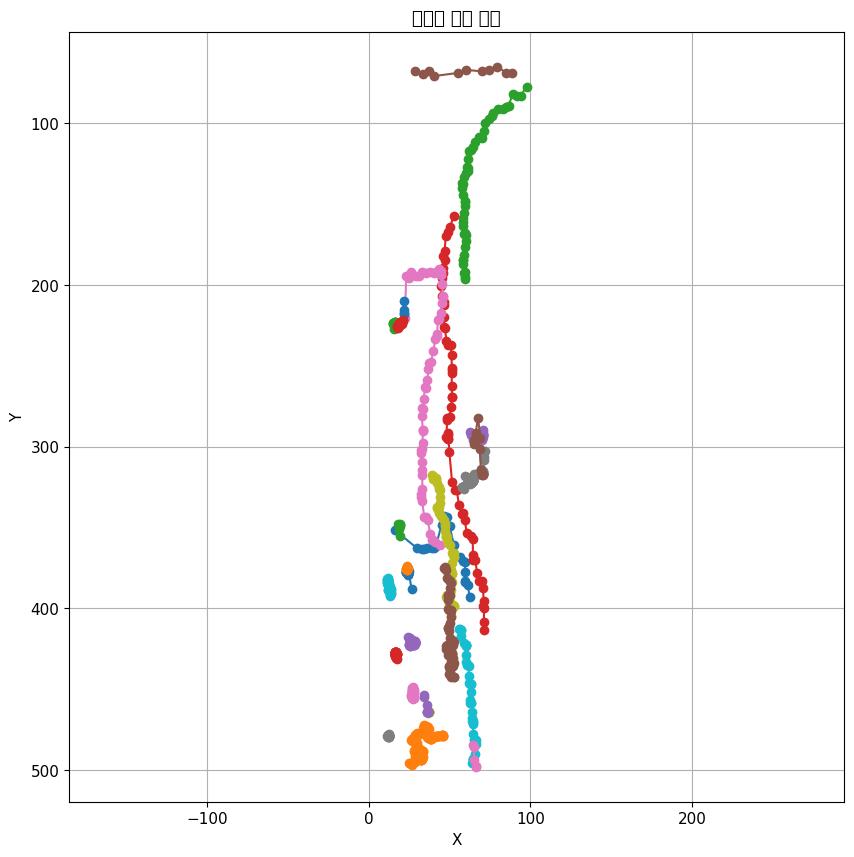

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict



# 원근 변환을 위한 소스 및 대상 점 정의
src_points = np.float32([[378,260],[688,260],[1080,1745],[0,1745]])
dst_points = np.float32([[0, 0], [100, 0], [100, 500], [0, 500]])

# 원근 변환 행렬 계산
M = cv2.getPerspectiveTransform(src_points, dst_points)

# 객체별 경로를 저장할 defaultdict 생성
trajectories = defaultdict(list)

# 모든 프레임의 좌표에 대해 처리
for frame_coords in each_coord:
    for coord in frame_coords:
        frame, obj_id, x, y = coord
        # 좌표에 원근 변환 적용
        transformed_coord = cv2.perspectiveTransform(np.array([[x, y]], dtype='float32').reshape(-1, 1, 2), M)
        # 변환된 좌표를 객체 ID에 맞게 리스트에 추가
        trajectories[obj_id].append((frame, transformed_coord[0][0][0], transformed_coord[0][0][1]))

plt.clf()

# 각 객체별로 정렬된 좌표에 따라 경로 그리기
plt.figure(figsize=(10, 10))
for obj_id, path in trajectories.items():
    # 시간에 따라 경로 정렬
    sorted_path = sorted(path, key=lambda x: x[0])
    # 경로의 x, y 좌표를 분리
    x_coords, y_coords = zip(*[(x, y) for _, x, y in sorted_path])

    # 경로를 그림
    plt.plot(x_coords, y_coords, marker='o', label=f'Object {obj_id}')

# 시각화 설정
# plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('객체별 이동 경로')
plt.grid(True)
plt.axis('equal')  # 축의 스케일을 동일하게 설정

plt.gca().invert_yaxis()

# 결과 표시
plt.show()


## 히트맵

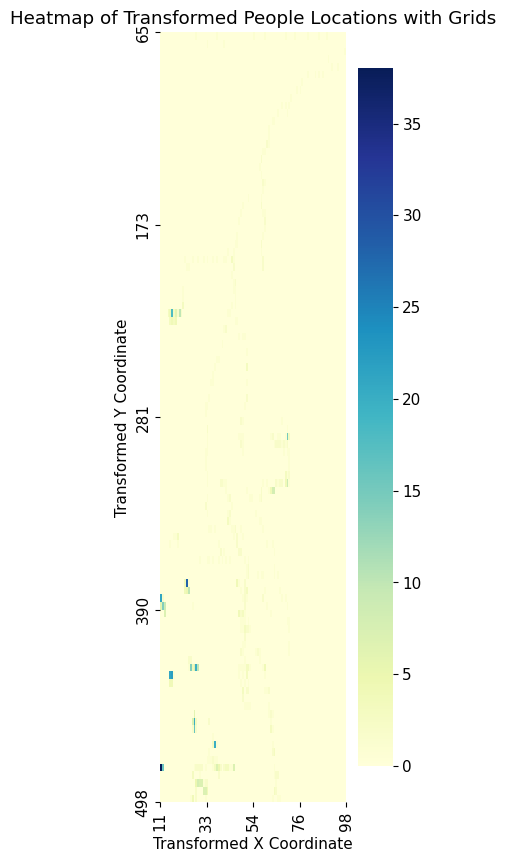

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# trajectories에서 좌표 데이터 추출
coords = []
for obj_id, path in trajectories.items():
    for frame, x, y in path:
        coords.append((x, y))

# 각 좌표에 대한 빈도수 계산
x_coords, y_coords = zip(*coords)
heatmap, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=(100, 100))

# 히트맵 시각화
plt.figure(figsize=(3, 10))
ax = sns.heatmap(heatmap.T, cmap="YlGnBu")
ax.set_xticks(np.linspace(0, heatmap.shape[1], num=5))
ax.set_yticks(np.linspace(0, heatmap.shape[0], num=5))
ax.set_xticklabels(['{:.0f}'.format(x) for x in np.linspace(xedges[0], xedges[-1], num=5)])
ax.set_yticklabels(['{:.0f}'.format(y) for y in np.linspace(yedges[0], yedges[-1], num=5)])

plt.title('Heatmap of Transformed People Locations with Grids')
plt.xlabel('Transformed X Coordinate')
plt.ylabel('Transformed Y Coordinate')
plt.show()
